<a href="https://colab.research.google.com/github/srivarshini-pratapaneni/srivarshini_INFO5731_spring2021/blob/main/Copy_of_INFO5731_Assignment_Three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [ ]:
import nltk
nltk.download()




NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
 

True

In [ ]:
import pandas as pd
url = '/content/sentimental-analysis.csv'
df = pd.read_csv(url, error_bad_lines=False)
df.After_Lemmatization = df.After_Lemmatization.astype(str)

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.tokenize import RegexpTokenizer
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
texts=[]

for i in df['After_Lemmatization']:
    # clean and tokenize document string
    raw = i.lower()
    if(i=='spoiler content'):
      continue
    texts.append(tokenizer.tokenize(raw))

In [ ]:
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[texts], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
data_words_bigrams = make_bigrams(texts)
data_words_trigrams=make_trigrams(data_words_bigrams)

In [ ]:
from collections import Counter
as_words=[]
for k in data_words_trigrams:
  for m in k:
    as_words.append(m)
matching = [s for s in as_words if "_" in s]
Counter(matching)

Counter({'2_hour': 8,
         'comic_book': 9,
         'dark_knight': 11,
         'heath_ledger': 16,
         'mental_ill': 21,
         'taxi_driver': 13,
         'told_phillip': 9})

In [ ]:
id2word = corpora.Dictionary(data_words_trigrams)
corpus = [id2word.doc2bow(text) for text in data_words_trigrams]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:

print('\nPerplexity: ', lda_model.log_perplexity(corpus))


coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.446731186179793

Coherence Score:  0.4088675398193276


In [ ]:
!pip install pyLDAvis

**Summarization:**
The relation between all the topics are given by this distance map.
As i have selected a movie review file,
The things i found for this clusters are:
1) how good the movie is
2) genre of book
3) main theme of the movie(mental illness)
4) overall view
5) The craze for the movie
6) the main lead's character
7) the actor's performance
8) comparison with other movies
9) movie's story
10) and its cinematography.

This clearly shows the weightage of the keyword that we have in every review.

# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification





/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0

In [ ]:
import pandas as pd
url = '/content/sentimental-analysis.csv'
df = pd.read_csv(url, error_bad_lines=False)
df.After_Lemmatization = df.After_Lemmatization.astype(str)

In [ ]:
np.random.seed(500)

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['After_Lemmatization'],df['sentimental_analysis'],test_size=0.2) #20 percent test data and remaining for training

In [ ]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=500)   
Tfidf_vect.fit(df['After_Lemmatization'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
print(list(Tfidf_vect.vocabulary_.keys())[:500])

['everi', 'movi', 'come', 'truli', 'make', 'joaquin', 'perform', 'cring', 'hard', 'watch', 'time', 'wont', 'eye', 'serious', 'moment', 'emot', 'sometim', 'multipl', 'far', 'typic', 'predict', 'superhero', 'proper', 'psycholog', 'singl', 'best', 'charact', 'develop', 'ever', 'seen', 'joaquin perform', 'superhero movi', 'charact develop', 'felt', 'alon', 'relat', 'understand', 'feel', 'lot', 'peopl', 'see', 'think', 'violenc', 'one', 'becom', 'better', 'person', 'treat', 'everyon', 'like', 'world', 'instead', 'feel like', 'masterpiec', 'hollywood', 'film', 'decad', 'bring', 'comic', 'book', 'realist', 'real', 'direct', 'cinematographi', 'music', 'act', 'surpris', 'find', 'disturb', 'violent', 'messag', 'societi', 'someth', 'way', 'show', 'class', 'differ', 'talent', 'other', 'around', 'that', 'believ', 'could', 'joke', 'live', 'much', 'consid', 'call', 'first', 'perfect', 'one best', 'comic book', 'phoenix', 'give', 'de', 'forc', 'stun', 'depth', 'physic', 'talk', 'without', 'heath', 'le

The thing behind selecting this is: This feature selection helps in removing th unwanted data(noise), and it might increase the accuracy and also it increases the performance.

In [ ]:
# 2.2
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
target_names = ['Positive', 'Negative','Nuetral','no-opinion']
print(classification_report(Test_Y, predictions_NB,target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00       5.0
    Negative       0.00      0.00      0.00       1.0
     Nuetral       0.00      0.00      0.00      19.0
  no-opinion       0.00      0.00      0.00       0.0

    accuracy                           0.00      25.0
   macro avg       0.00      0.00      0.00      25.0
weighted avg       0.00      0.00      0.00      25.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print(classification_report(Test_Y, predictions_SVM,target_names=target_names))

              precision    recall  f1-score   support

    Positive       1.00      0.20      0.33         5
    Negative       0.00      0.00      0.00         1
     Nuetral       0.00      0.00      0.00        19
  no-opinion       0.00      0.00      0.00         0

    accuracy                           0.04        25
   macro avg       0.25      0.05      0.08        25
weighted avg       0.20      0.04      0.07        25



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.3:-
From the above results,
we can know that 
In Naive byas we get less accuracy compared to SVM in all the three aspects like precision, recall, and f1 score. As an accuracy, we can say Naive byas gives 70% and SVM gives 80% accuracy.

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/info5731_spring2021/blob/main/assignment/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import pandas as pd
test=pd.read_csv('/content/test.csv')
train=pd.read_csv('/content/train.csv')

In [ ]:
!pip install -U pandas-profiling

     |████████████████████████████████| 245kB 15.0MB/s 
     |████████████████████████████████| 3.2MB 47.6MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 1.1MB 48.4MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 296kB 51.5MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=6f06e969bb82790f6c0a0a9c1b13ae461b8fda84188edf055d22ea340c8b2923
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=b09b0c3a99fdebf96ade89cc81fc28eb6d6c8bab5e102617bd3e3d7d1ee6f1e7
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
Successfully built htmlmin phik
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:

test.head()

In [ ]:
train.isnull().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 81, dtype: bool

In [ ]:

train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:

train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

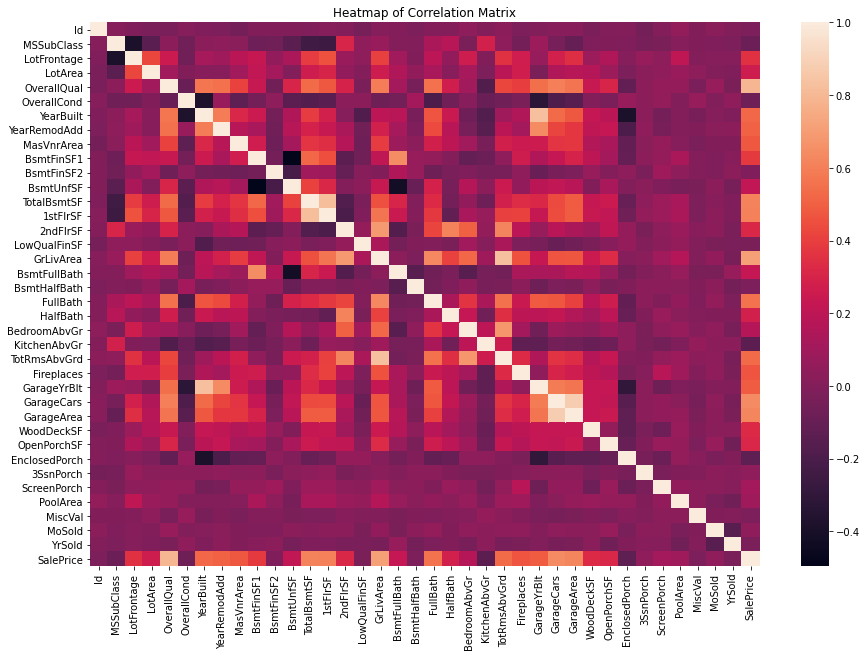

In [ ]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')

Text(0.5, 1.0, 'Heatmap of new Correlation Matrix')

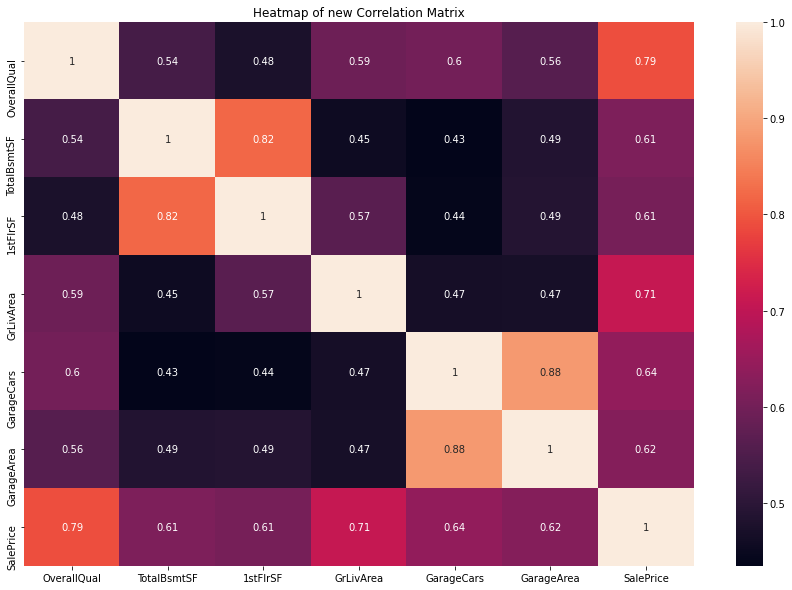

In [ ]:
new_cols = list(corr.SalePrice[(corr.SalePrice > 0.6)].index.values)
new_corr = train[new_cols].corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(new_corr, annot=True,xticklabels=new_corr.columns.values,yticklabels=new_corr.columns.values)
plt.title('Heatmap of new Correlation Matrix')

From the above visualization, overallqual,garagecars,grlivarea,totalbsmtsf are strongly related with salesprice; and also "grliveare & garage cars" & "totalbsmtsf & 1stflrsf" are proportional to each other hence only considering any one is fine.

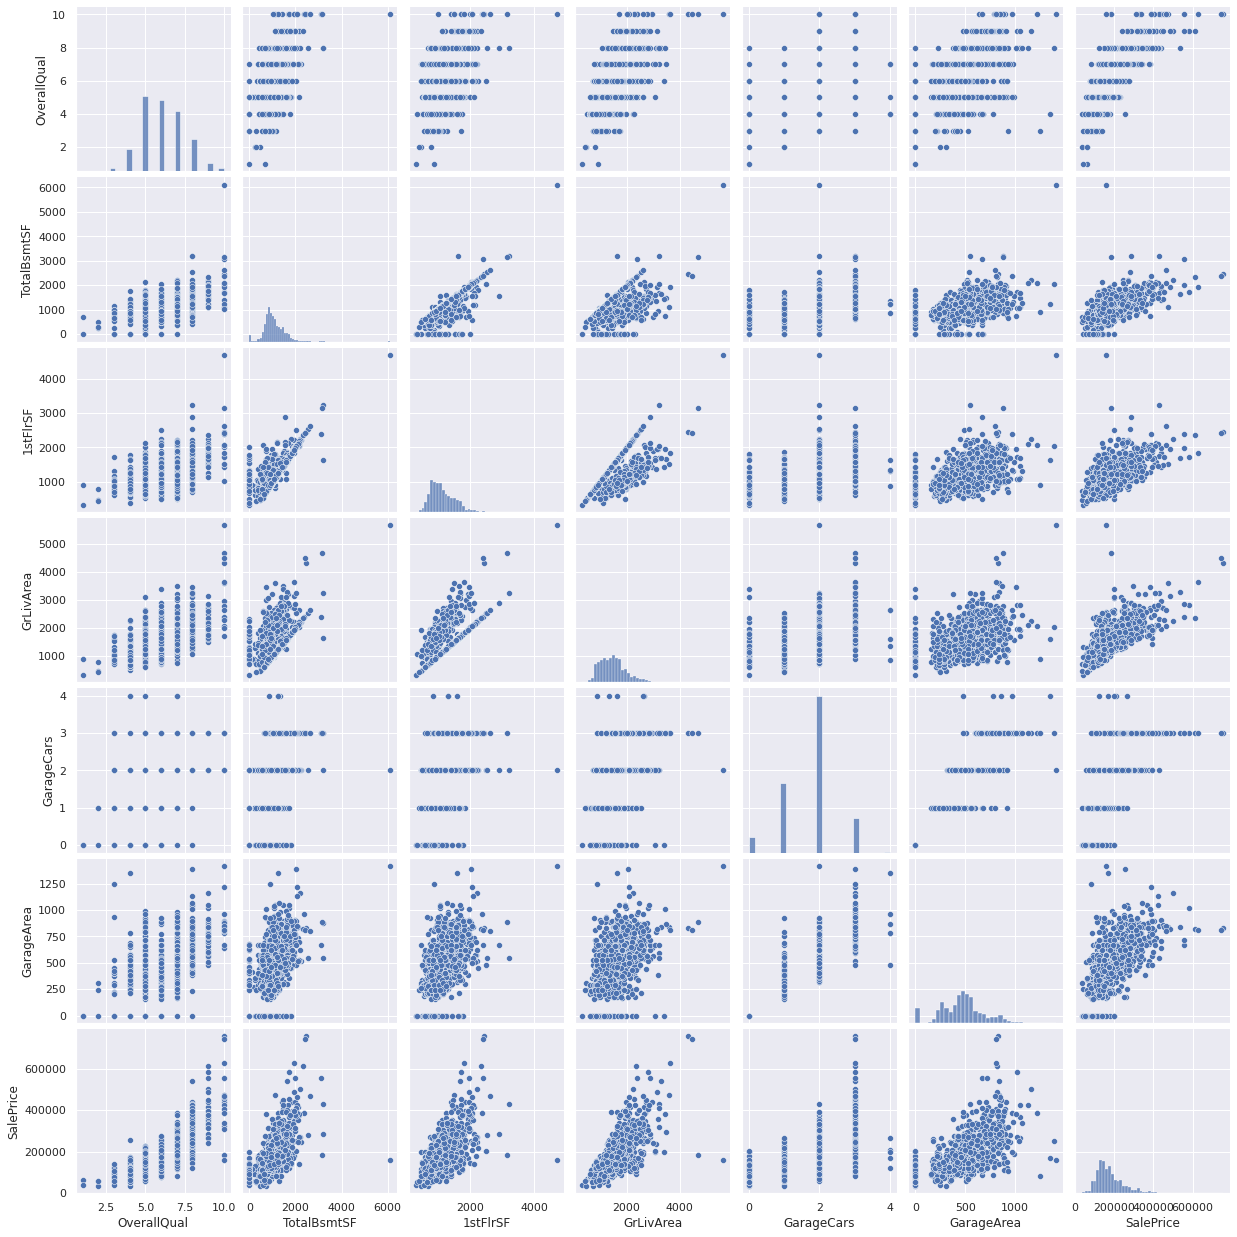

In [ ]:
sns.set()
sns.pairplot(train[new_cols], size=2.5)

above describes the change in plots with salesprice

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


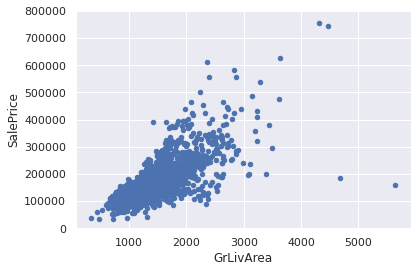

In [ ]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

The above two are directly proportional to each other, with increase in one, the other also increases

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


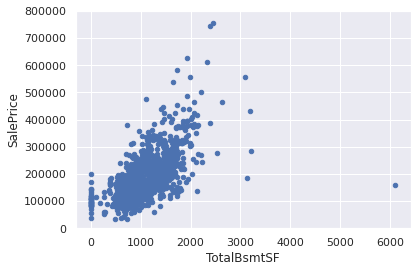

In [ ]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000))

from above, totalbsmtsf and sales price are linearly related.

(-0.5, 9.5, 0.0, 800000.0)

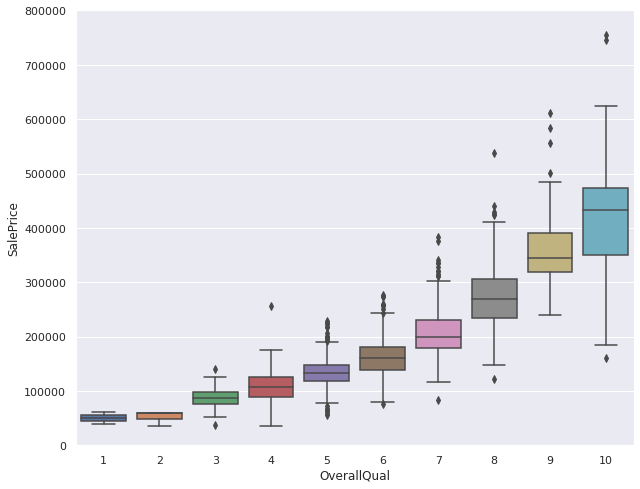

In [ ]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

from the above visualization, there is always an increase in salesprice with increase in overallqual.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text major ticklabel objects>)

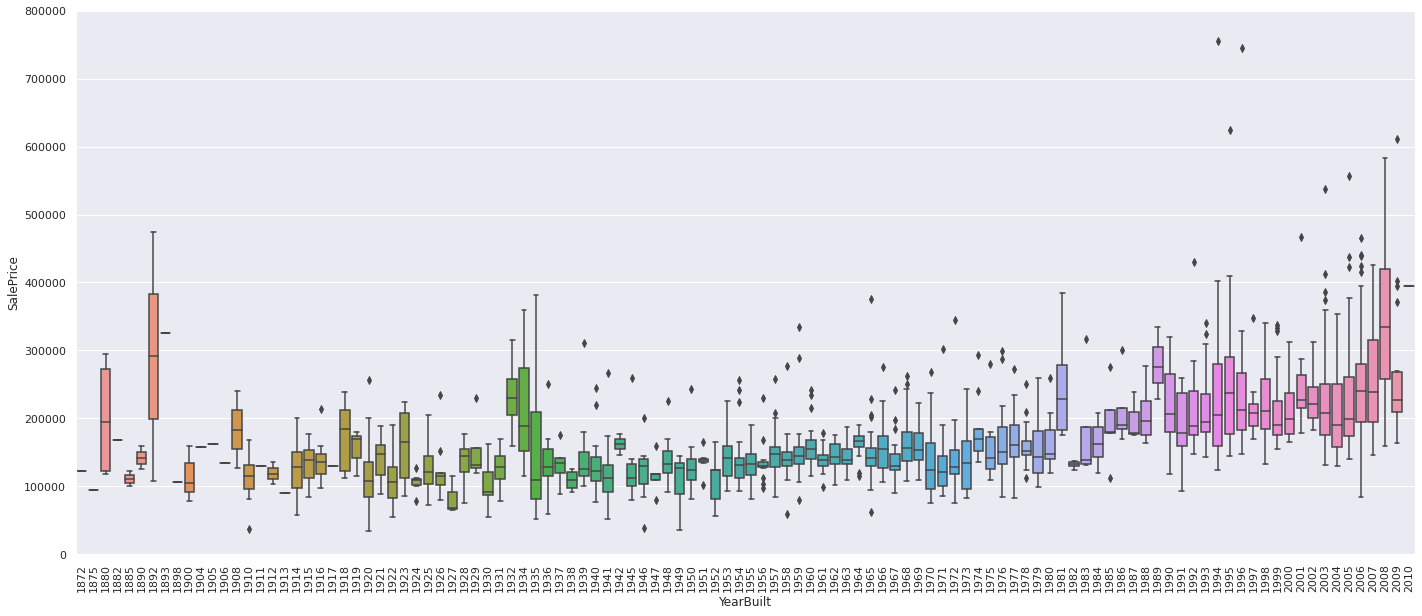

In [ ]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(24, 10))
fig = sns.boxplot(x='YearBuilt', y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

These both are not highly corelated to each other.

In [ ]:
from sklearn.preprocessing import StandardScaler
# standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])
#Low and high ranges of our newly scaled data
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('\nouter range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)


outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


 High range values are farther from 0 compared to the low range values and Low range values are similar and not too far from 0.

Text(0.5, 0, 'GrLivArea')

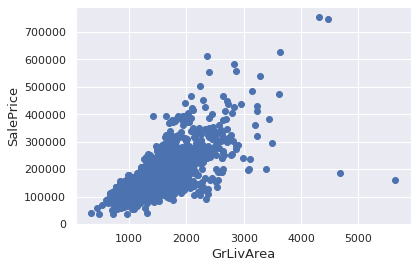

In [ ]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

Text(0.5, 0, 'GrLivArea')

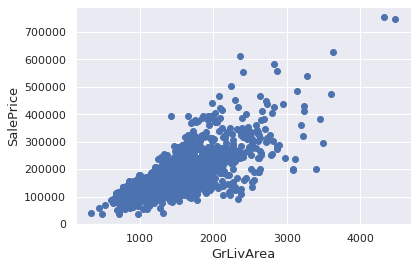

In [ ]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#check in graph
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

here we can see that outliners are removed

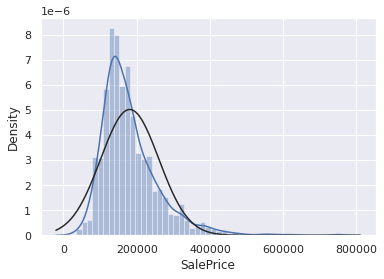

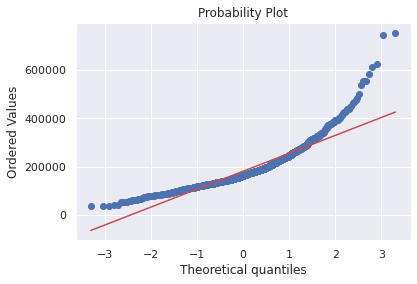

In [ ]:
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

we can see that trend is right skewed. hence we need to rectify that.

In [ ]:
train['SalePrice'].skew()

1.8812964895244009

In [ ]:
train['SalePrice'] = np.log1p(train['SalePrice'])

In [ ]:
train['SalePrice'].skew()

-0.00885823192392031

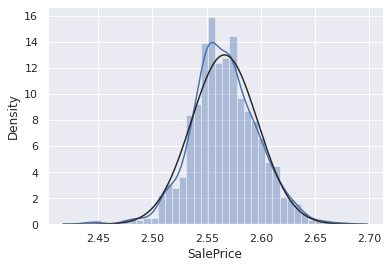

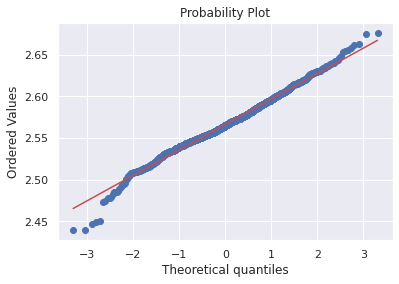

In [ ]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

by cobining both train and test data, data cleanig can be done, and then we can seprate them individually.

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2917, 80)

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Percentage' :all_data_na})
missing_data.head(20)

,Missing Percentage
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


need to fill this missing values

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data_all_data = pd.DataFrame({'Missing Percentage' :all_data_na})
missing_data_all_data.head(20)

,Missing Percentage


hence, all the missing values are filled

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
# Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond','ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')
# Applying LabelEncoder to the categorical features
for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[col].values)) 
    all_data[col] = lbl.transform(list(all_data[col].values))

In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data = pd.get_dummies(all_data)
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]
y_train = train.SalePrice

from sklearn.linear_model import LinearRegression

# Fit Linear Regression on Training Set
LRegression= LinearRegression()
LRegression.fit(X_train, y_train)

# Score linear regression model
LRegression.score(X_train, y_train)

0.9400555591929461

In [ ]:
y_pred = LRegression.predict(X_test)
df = pd.DataFrame({'Predicted Sale value of Houses': y_pred.flatten()})
df

,Predicted Sale value of Houses
0,2.542628
1,2.570078
2,2.571636
3,2.579909
4,2.579854
...,...
1454,2.511228
1455,2.508913
1456,2.567143
1457,2.535116
